In [1]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

np.random.seed = 42

In [2]:
genre_list = [
    "unknown",
    "action",
    "adventure",
    "animation",
    "children",
    "comedy",
    "crime",
    "documentary", 
    "drama", 
    "fantasy",
    "film-noir",
    "horror",
    "musical",
    "mystery",
    "romance",
    "sci-Fi",
    "thriller",
    "war",
    "western",
]
ratings = pd.read_csv("movielens/raw/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
users = pd.read_csv("movielens/raw/u.user", sep="|", encoding="latin-1", names=["user_id", "age", "gender", "occupation", "zip"])
items = pd.read_csv("movielens/raw/u.item", sep="|", encoding="latin-1", names=[
        "item_id",
        "title",
        "release_date",
        "video_release_date",
        "imdb_url"] + genre_list
)
num_sparse_features = {
    "user_id": users["user_id"].nunique(),
    "item_id": items["item_id"].nunique(),
    "gender": users["gender"].nunique(),
    "occupation": users["occupation"].nunique(),
    "genre": len(genre_list),
}
dense_features = ["age"]

vocabulary = {
    "user_id": np.unique(users["user_id"]),
    "item_id": np.unique(items["item_id"]),
    "gender": np.unique(users["gender"]),
    "occupation": np.unique(users["occupation"]),
    "genre":np.array(genre_list)
}

In [3]:
# 인기 장르를 대표 장르로 설정
item_genre_counts = items.melt(
    id_vars="item_id",
    value_vars=genre_list,
    var_name="genre",
    value_name="is_genre"
)
genre_popularity = item_genre_counts[item_genre_counts["is_genre"]==1].groupby("genre")["item_id"].nunique().sort_values()
items["genre"] = "unknown"
for genre, count in genre_popularity.items():
    items.loc[items[genre] == 1, "genre"] = genre

# 사용할 데이터만 남기기
processed_users = users[["user_id", "gender", "occupation", "age"]].copy()
processed_items = items[["item_id", "genre"]].copy()

# sparse feature 전처리 하기
for feature_name in vocabulary:
    vocab = {v:i for i, v in enumerate(vocabulary[feature_name])}
    if feature_name in processed_users:
        processed_users[feature_name] = processed_users[feature_name].map(vocab)
    else:
        processed_items[feature_name] = processed_items[feature_name].map(vocab)

    if feature_name in ratings:
        ratings[feature_name] = ratings[feature_name].map(vocab)

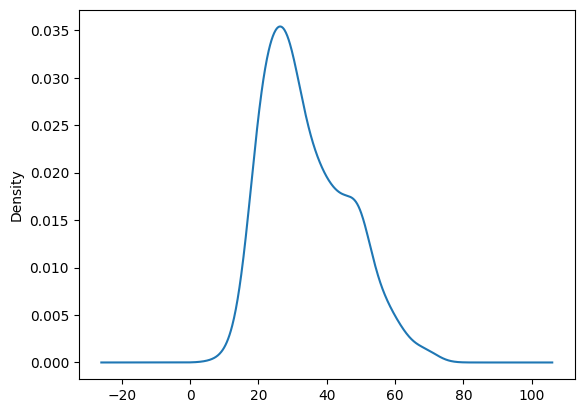

In [4]:
# dense feature 전처리 -> 직접 하나하나 해야함!
processed_users["age"].plot.density()

# 너무 크거나 작은 값은 내림/올림
N_age = processed_users["age"].agg(["mean", "std"])
processed_users["age"] = processed_users["age"].clip(10, 70)
processed_users["age"] = (processed_users["age"] - N_age["mean"]) / N_age["std"]

In [5]:
# Dataset Hyperparameter
processed = ratings.copy()
maximum_positive_sample = 100
num_negative_sample = 5
all_item_indices = np.arange(num_sparse_features["item_id"])

# Leave-one-out split
# Downsampling
# Random Negative Sampling
train, test = [], []
grouped = processed.sort_values(by="timestamp").drop("timestamp", axis=1).groupby("user_id")
for u, group in tqdm(grouped):
    # Leave one
    test_item_id = group.iloc[-1, 1]
    test_negative = np.column_stack([
        np.full(len(all_item_indices), u, dtype=int),
        all_item_indices,
        np.zeros(len(all_item_indices), dtype=int)
    ])
    test_negative[test_item_id, 2] = 1
    test_negative = pd.DataFrame(test_negative, columns=["user_id", "item_id", "rating"])
    test.append(pd.concat([test_negative], axis=0))


    # Downsampl
    positive = group.iloc[:-1, ].copy()
    positive["rating"] = 1
    num_positive_sample = len(positive)
    num_positive_sample = min(maximum_positive_sample, num_positive_sample)
    positive = positive.tail(num_positive_sample)    

    # negative sampling
    positive_item_indices = positive["item_id"].unique()
    negative_item_indices = np.setdiff1d(all_item_indices, positive_item_indices)
    
    size = num_positive_sample * num_negative_sample
    replace_flag = size > len(negative_item_indices)
    negative_item_indices = np.random.choice(
        negative_item_indices,
        size=size,
        replace=replace_flag
    )

    negative = np.column_stack([
        np.full(size, u, dtype=int),
        negative_item_indices,
        np.zeros(size, dtype=int)
    ])
    negative = pd.DataFrame(negative, columns=["user_id", "item_id", "rating"])
    
    
    train.append(pd.concat([positive, negative], axis=0))


train = pd.concat(train, axis=0)
test = pd.concat(test, axis=0)

100%|███████████████████████████████████████| 943/943 [00:00<00:00, 1763.06it/s]


In [6]:
# 데이터 합치기
processed_train = train.merge(processed_users, how="left", on="user_id")
processed_train = processed_train.merge(processed_items, how="left", on="item_id")


processed_test = test.merge(processed_users, how="left", on="user_id")
processed_test = processed_test.merge(processed_items, how="left", on="item_id")

processed_train.isnull().any(), processed_test.isnull().any()

(user_id       False
 item_id       False
 rating        False
 gender        False
 occupation    False
 age           False
 genre         False
 dtype: bool,
 user_id       False
 item_id       False
 rating        False
 gender        False
 occupation    False
 age           False
 genre         False
 dtype: bool)

In [7]:
# 대조군(Popular), 대조군(Random)
popular_recommendations = processed_train.loc[processed_train["rating"]==1, "item_id"].value_counts().index.values
random_recommendations = np.random.choice(vocabulary["item_id"], size=len(all_item_indices), replace=False)

In [8]:
# save in processed
with open("movielens/processed/num_sparse_features.json", "w") as f:
    json.dump(num_sparse_features, f)
    
with open("movielens/processed/dense_features.json", "w") as f:
    json.dump(dense_features, f)
    
with open("movielens/processed/experiment_group.json", "w") as f:
    json.dump({
        "random":random_recommendations.tolist(), 
        "popular":popular_recommendations.tolist(),
    }, f)
    

processed_train.to_parquet("movielens/processed/train.parquet")
processed_test.to_parquet("movielens/processed/test.parquet")